# Market Basket Analysis using Apriori Algorithm

As part of this assignment, you are expected to fill the blanks in the code provided in the Jupyter Notebook

In [1]:
# Defining the environment variables 

import os
import sys
os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3"
os.environ["JAVA_HOME"] = "/usr/java/jdk1.8.0_161/jre"
os.environ["SPARK_HOME"] = "/home/ec2-user/spark-2.4.4-bin-hadoop2.7"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
sys.path.insert(0, os.environ["PYLIB"] +"/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] +"/pyspark.zip")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
6,application_1653540358479_0007,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
# Importing the SparkSession library

from pyspark.sql import SparkSession

MAX_MEMORY = "5g"

# Creating the SparkSession object

spark = SparkSession.builder \
                    .appName('apriori')\
                    .config("spark.executor.memory", MAX_MEMORY) \
                    .config("spark.driver.memory", MAX_MEMORY) \
                    .getOrCreate()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
spark

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
# Loading the data from Market_Basket_Optimisation.csv inside the dataframe
transaction_df = spark.read.csv("s3://aws-emr-resources-549124685073-us-east-1/notebooks/e-744HPEZYE0OVNCMK5PZ595E5G/transactions.csv")

# Schema of the dataframe
transaction_df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)
 |-- _c10: string (nullable = true)
 |-- _c11: string (nullable = true)
 |-- _c12: string (nullable = true)
 |-- _c13: string (nullable = true)
 |-- _c14: string (nullable = true)
 |-- _c15: string (nullable = true)
 |-- _c16: string (nullable = true)
 |-- _c17: string (nullable = true)
 |-- _c18: string (nullable = true)
 |-- _c19: string (nullable = true)

In [5]:
# Print the first 20 transactions of the dataframe
transaction_df.createTempView("transaction_df_table")
spark.sql("select * from transaction_df_table limit 20").show(20, truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+------------+-------------+----------------+-------------+----------------+--------------+--------------+------------+--------------------+--------------+---------+-----+-----+-------------+------+-----------------+---------------+-------+---------+
|_c0              |_c1         |_c2          |_c3             |_c4          |_c5             |_c6           |_c7           |_c8         |_c9                 |_c10          |_c11     |_c12 |_c13 |_c14         |_c15  |_c16             |_c17           |_c18   |_c19     |
+-----------------+------------+-------------+----------------+-------------+----------------+--------------+--------------+------------+--------------------+--------------+---------+-----+-----+-------------+------+-----------------+---------------+-------+---------+
|shrimp           |almonds     |avocado      |vegetables mix  |green grapes |whole weat flour|yams          |cottage cheese|energy drink|tomato juice        |low fat yogurt|green tea|honey|sala

## Apriori Algorithm

You are already familiar with the Apriori algorithm. The points below summarise the entire algorithm for revision purposes.

The Apriori algorithm mainly involves two parts:
<br> 
- Part A: Frequent Itemset Generation
<br> 
- Part B: Rule Generation

Frequent Itemset Generation in Apriori Algorithm:

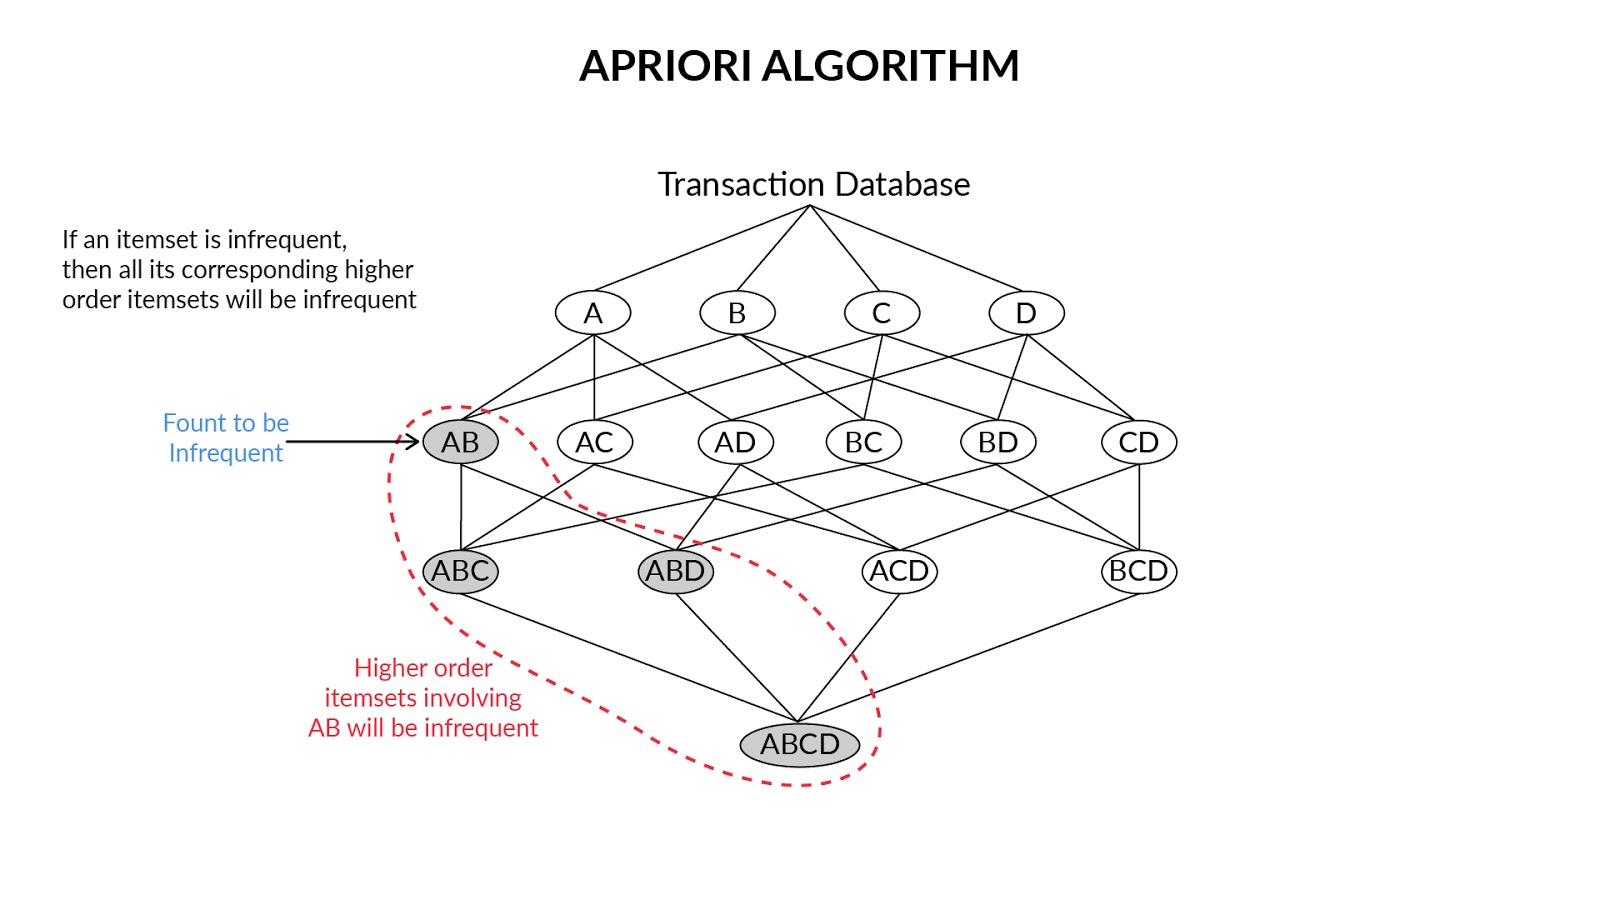

- The first step of the algorithm is to identify distinct items in the given set of transactions. Let’s say these are ({A}, {B}, {C}, {D}).

- Once you have different items, your next step would be to calculate the support of each of these items. Items with support values less than the minimum support are removed from the distinct items list.

- The next step is to create higher-order itemsets by merging the existing itemsets. This can be done using the candidate generation technique. We will cover this concept in detail while implementing the generation of higher item sets on code.

- Using the 1 itemsets ({A}, {B}, {C}, {D}) and assuming that only A, B and C are frequent, we generate itemsets {A, B}, {A, C} and {B, C}. Note that none of the 2-item sets contains the item D. This is because we have applied the Apriori principle. Since D is infrequent, any item set containing D, e.g., {A, D}, {C, D} and {B, C, D} will automatically become infrequent.

- Once you have the higher-order itemsets, you can calculate the support for these item sets and again remove the itemsets that do not qualify the minimum support criteria.

- This ( n-1 ) -item sets then become inputs for the generation of n-item sets, and once again the item sets that do not satisfy the minimum support criteria are removed. This process continues until no new itemsets can be generated.

 

Rule Generation in the Apriori Algorithm:

- Once you have all the frequent itemsets, we can proceed with the rule generation process. We begin with 2-itemsets and generate all the possible rules.

- For each rule, we check the corresponding confidence value and return the rule only if its confidence is above the minimum confidence level.

- In order to avoid generating redundant rules, we utilise confidence-based pruning. Using this, we eliminate the generation of higher-order rules if their corresponding lower-order rules are infrequent. This portion will be explained in more detail in the code demonstration of rule generation.

### Part A. Frequent Itemset generation

This part of the algoritm is divided as follows:

- Extracting unique items

- Computing the support value for individual itemsets

- Generating higher-order itemsets

- Combining the functions above to generate all the frequent itemsets


We have defined different functions to perfrom the tasks mentioned above. All the functions are called under the main function **'apriori()'** that is defined in the later parts of the notebook. You can refer to the function to understand the purpose of each function and how they are called to perform the required task.

Let's see each of them one by one.

Functions defined:
 - generate_unique_item_set() - To generate the dataFrame that holds all the unique items in the transaction base in a single column
 
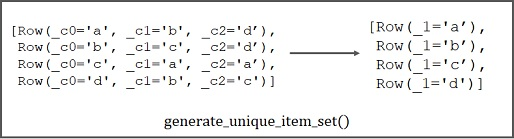
 
 - remove_duplicate_columns() - Remove the columns with duplicate values
 
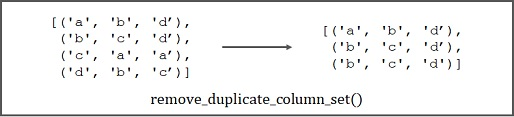

In [6]:
# Function to remove the columns with duplicate values

def remove_duplicate_columns(x):
    # Length of the column
    col_len = len(x)
    
    # Empty RDD - set of values
    columns = set()
    
    # Removing any additional spaces from the elements and adding the elements into the column from RDD 'x'
    for col in range(col_len):
        x_col = str(x[col]).strip()
        columns.add(x_col)
    
    # To check if elements are present in the provided dataframe/RDD 
    if len(columns) < col_len:
        return []
    
    # Returning the sorted list of items in each element as tuple
    return [(tuple(sorted(columns)))]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Reasoning
What is the use of strip() funciton in defining the remove_duplicate_columns() function?

`split()` removes any unwanted preceding or tailing blanks

In [7]:
# For the given dataset writing a function to return the list of distinct items in the dataset

def generate_unique_item_set(df):
    # empty dataframe
    total_item_set_df = None
    
    # Iteration over each column - 20 columns
    for col_index in range(20):
        
        # Loading the elements of each column individually
        _c_df = df.select("_c" + str(col_index))
        
        if total_item_set_df is None:
            # None for the first iteration in the loop
            total_item_set_df = _c_df
            
        else:
            # After the first iteration, appending the entries from each column to total_item_set_df
            total_item_set_df = total_item_set_df.union(_c_df)
            
    # Return Value: Dataframe with unique items (no repetition) and null values removed from the dataFrame        
    
    # df.na provides all the null values; all the null values must be dropped
    # .rdd converts the DataFrame to RDD
    # remove_duplicate_columns must be applied to elements of RDD such that each item in transaction is a separate element 
    # Remember that the function 'remove_duplicate_columns' is applied to each element of the RDD, in short, every row of the dataframe should be passed into it. 
    
    return total_item_set_df.select("_c0").na.drop().rdd.flatMap(remove_duplicate_columns).distinct().toDF()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Reasoning

Can you tell why only the column '\_c0' is extracted from the function above? Provide your answer below.

(Write your answer here)

<br> Use the above function **generate_unique_item_set** and the dataframe **transaction_df** to create the dataFrame **item_set** that stores the the name of all the items in the transaction base as independent elements. <br>

In [8]:
# Syntax structure: item_sets = function(dataframe)

item_sets = generate_unique_item_set(transaction_df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
# Print the first twenty rows of the item_sets dataframe
item_sets.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|                  _1|
+--------------------+
|   whole wheat pasta|
|            pancakes|
|            zucchini|
|         blueberries|
|           asparagus|
|              shrimp|
|             burgers|
|           spaghetti|
|         french wine|
|       strong cheese|
|extra dark chocolate|
|              melons|
|               cream|
|           meatballs|
|   frozen vegetables|
|            escalope|
|          energy bar|
|        energy drink|
|      vegetables mix|
|          body spray|
+--------------------+
only showing top 20 rows

In [10]:
# Give the number of unique items in the transaction dataset
item_sets.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

119

<br>The itemset should contain all the unique items in the dataframe after you have removed all the duplicate values. Now, this dataframe will be helpful in creating the frequent item set ahead.

__________________________

Now, you will have the first order candidate itemset inside a dataframe. This dataframe will be used in generating the frequent itemset of different orders. Following functions have been defined to help you obtain the frequent itemset:

 - filter_and_map_transaction()
 - get_all_possible_candidate_sets()
 - get_freq_item_sets()
 - is_freq_item_set_not_empty()
 - apriori()
 

<br>**filter_and_map_transaction()**
<br> <br>The function is expected to compare each item sold by the company with the candidate set. If the item is present in the transaction, the corresponding item in the candidate set must be mapped with value 1 and if they are absent, then the value must be 0.

Refer to the image provided after the function definition.

In [11]:
def filter_and_map_transaction(x, candidate_set_shared):
    
    c_k = []
    
    rows = len(candidate_set_shared.value)
    cols = len(candidate_set_shared.value[0])
    
    # Checking each transaction
    for row_i in range(rows):
        item_set = set()
        for col_i in range(cols):
            item_set.add(candidate_set_shared.value[row_i][col_i])
        
        # Map the condition with the correct value (1/0)
        if item_set.issubset(set(x)):
            c_k.append((candidate_set_shared.value[row_i], 1))
        else:
            c_k.append((candidate_set_shared.value[row_i], 0))
    return c_k

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Sample: The items from the first transaction are displayed along with the function. You can check how the values are mapped with 1 and 0.

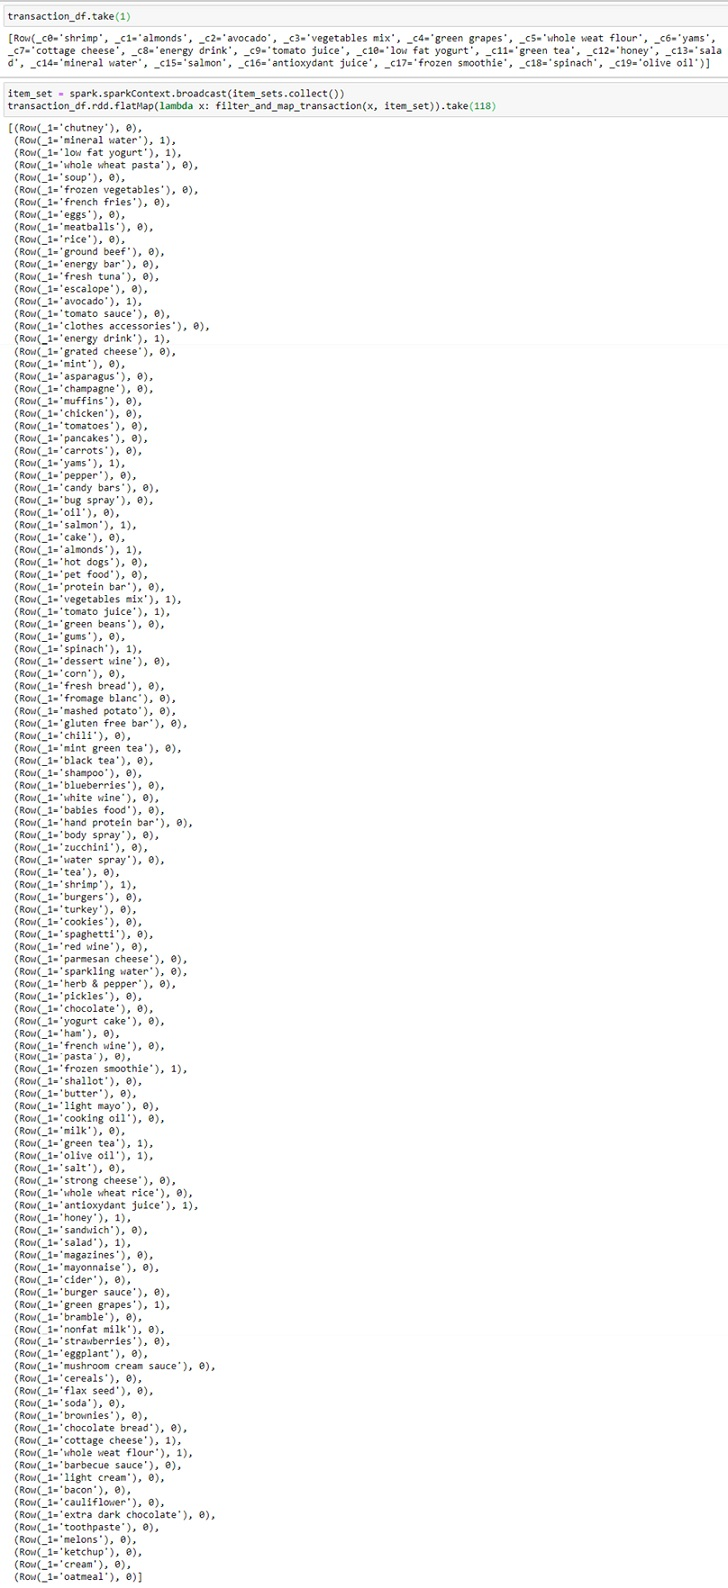

<br>

In [12]:
transaction_df.take(1)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(_c0='shrimp', _c1='almonds', _c2='avocado', _c3='vegetables mix', _c4='green grapes', _c5='whole weat flour', _c6='yams', _c7='cottage cheese', _c8='energy drink', _c9='tomato juice', _c10='low fat yogurt', _c11='green tea', _c12='honey', _c13='salad', _c14='mineral water', _c15='salmon', _c16='antioxydant juice', _c17='frozen smoothie', _c18='spinach', _c19='olive oil')]

In [13]:
item_set = spark.sparkContext.broadcast(item_sets.collect())
transaction_df.rdd.flatMap(lambda x: filter_and_map_transaction(x, item_set)).take(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[(Row(_1='whole wheat pasta'), 0), (Row(_1='asparagus'), 0), (Row(_1='pancakes'), 0), (Row(_1='blueberries'), 0), (Row(_1='zucchini'), 0), (Row(_1='spaghetti'), 0), (Row(_1='burgers'), 0), (Row(_1='shrimp'), 1), (Row(_1='strong cheese'), 0), (Row(_1='french wine'), 0), (Row(_1='melons'), 0), (Row(_1='extra dark chocolate'), 0), (Row(_1='cream'), 0), (Row(_1='frozen vegetables'), 0), (Row(_1='meatballs'), 0), (Row(_1='energy bar'), 0), (Row(_1='escalope'), 0), (Row(_1='energy drink'), 1), (Row(_1='mint'), 0), (Row(_1='vegetables mix'), 1)]

**get_all_possible_candidate_sets()**
<br> <br>The function is used to generate itemsets of higher order from the first order. The value 'k+1' denotes the order number and the function creates itemsets of order 'k+1' by merging the two input itemset of order k & 1 respectively.

In [14]:
def get_all_possible_candidate_sets(candidate_item_sets_k, candidate_item_sets_0):
    
    # Convert the elements of the candidate_item_sets_k from the list format into tuple
    # You can refer to the commands below to check why only the first element is used for conversion
    candidate_item_sets_k = candidate_item_sets_k.map(lambda x: tuple(x[0])).toDF()
    # toDF() converts the rdd into a dataFrame
    
    # Returning the k+1 order
    return candidate_item_sets_k.crossJoin(candidate_item_sets_0).rdd.flatMap(remove_duplicate_columns).distinct()
    # crossJoin will help to combine one element of one dataFrame with all the elements of another dataFrame

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Reasoning

What is the purpose of using the function crossjoin()? You can check the documentation to understand the output of the function.

The `crossjoin()` is used to generate a paired combination of each row of the first table with each row of the second table.

<br>**get_freq_item_sets()**
<br> <br>The function is used to generate filtered itemsets from the provided dataFrame based on the minimum support value. It filters candidates sets by the minimum support set by main Apriori function. Output of this should be repeatedly added in a array to generate the final output of main apriori function.

In [15]:
def get_freq_item_sets(total_records, candidate_sets_shared, transaction_df_rdd, min_support):

    """
    Attributes
    ----------
    total_records: Total number of records in the dataFrame
    
    candidate_sets_shared: List of items in the transaction base
    
    transaction_df_rdd: Transactions dataFrame converted into an RDD
    
    min_support: Minimum support threshold
    ----------
    
    """
    
#     filtered_item_set = transaction_df_rdd.flatMap(lambda x: filter_and_map_transaction(x, candidate_sets_shared)) \
                                          
#                                           # Sample output from filter_and_map_transaction function can be seen above
#                                           # Now complete the function to generate the frequent item set
#                                           # support value = Frequency of the item in the transactions/total number of transactions
                                          
#                                           # 1. function to calculate frequency of each item in the transaction base
#                                           .reduceByKey(sumOperator) \
                                          
#                                           # 2. funciton to calculate the support value (formula in comments above) 
#                                           # You are expected to provide the total number of records when you call the function.
#                                           .map(lambda freq_set: (freq_set[0], freq_set[1]/total_records)) \
                                          
#                                           # 3. funciton to filter the items that have support value greater than the min_support
#                                           # You are expected to provide the min_support when you call the function.
#                                           .filter(lambda item: item[1] >= min_support)

    filtered_item_set = transaction_df_rdd.flatMap(lambda x: filter_and_map_transaction(x, candidate_sets_shared)) \
        .reduceByKey(lambda x, y: x + y) \
            .map(lambda freq_set: (freq_set[0], freq_set[1]/total_records)) \
                .filter(lambda item: item[1] >= min_support)
    
    return filtered_item_set

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<br>**is_freq_item_set_not_empty()**
<br> <br>The function is used to check if the frequent itemset has any transactions or not.
<br>

In [16]:
# Function to check if "freq_item_sets" has relevant values (Not empty and all the values are not None)

# The first condition is defined to check if there are elements in the itemset. 
# There might be a case that elements are present but all of them are none.
# The second condition checks if all the elements of the itemset are not none.

def is_freq_item_set_not_empty(freq_item_sets):
    return (freq_item_sets.count() > 0) and (freq_item_sets is not None)
    
    # Provide the correct logical operator in the condition above 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<br>**apriori()**
<br> <br>This is the main function and is used to return all frequent item sets along with their support values. It should return an array of Spark dataFrames. 

 - Array index should indicate the order of the frequent item set. For example data frame at index i should contain frequent item sets of order (i + 1).
 - Uses all the functions defined above to provide the results.
 

In [17]:
from pyspark.sql.types import StructType, ArrayType, StructField, DoubleType, StringType

def apriori(item_sets, transaction_df_rdd, min_support):
    
    """
    Attributes
    ----------
    item_sets: DataFrame that has all the items present in the transactions
    
    transaction_df_rdd: Transacations in the form of an RDD
    
    min_support: Minimum support threshold
    -----------
    """
    
    # Calculate the total number of transactions in the dataset and store the count in total_records
    total_records = transaction_df_rdd.count()

    # Defining a blank list that will store the frequent itemsets
    freq_item_sets_all_orders = []

    # Candidate sets of order 1 will be the complete item list from the transactions
    # As you can see, broadcast function is used here. It is used to broadcast a variable on all the executors.
    candidate_sets_order_1 = spark.sparkContext.broadcast(item_sets.collect())
    
    # Complete the function to generate the filtered item set of order 1. Check the function definition of 'get_freq_item_sets' to understand the attributes.
    frequent_item_sets_order_1 = get_freq_item_sets(total_records, candidate_sets_order_1, transaction_df_rdd, min_support)
    
    # Appending the results of frequent_item_sets_order_1 in the freq_item_sets_all_orders
    freq_item_sets_all_orders.append(frequent_item_sets_order_1)
    
    # Convert the elements of the rdd 'frequent_item_sets_order_1' into a dataFrame with each element as tuple
    frequent_item_sets_order_1_df = frequent_item_sets_order_1.map(lambda x: tuple(x[0])).toDF()
    
    
    # Generating higher order rules
    k = 0
    
    # Loop will run till higher order item sets can be generated
    while is_freq_item_set_not_empty(freq_item_sets_all_orders[k]):
        # Generating candidate sets of order k+1 
        current_candidate_sets = get_all_possible_candidate_sets(freq_item_sets_all_orders[k], frequent_item_sets_order_1_df)
        
        # Broadcasting candidate sets
        current_candidate_sets = spark.sparkContext.broadcast(current_candidate_sets.collect())
        
        # Filtering candidate sets to get the frequent item sets of order 'k+1' 
        current_frequent_item_sets = get_freq_item_sets(total_records, current_candidate_sets, transaction_df_rdd, min_support)
        
        # Appending the list 'freq_item_sets_all_orders' with the frequent itemset of order k+1
        freq_item_sets_all_orders.append(current_frequent_item_sets)
        
        # freq_item_sets_all_orders is a list of RDDs where the element k stores the frequent item set of order k+1  
        
        # increasing k by 1
        k += 1
    
    
    return freq_item_sets_all_orders

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

All the functions that we have created until now will come into play in the Apriori function. All the possible k-order itemsets will be generated, and the support will be calculated for each itemset. The freqItemsets of all orders will be stored
and returned once the function is called.

In [18]:
# Generate the frequent item set using the apriori function created above.
# Minimum support = 0.01
# Check the format in which each attribute must be provided

min_support = 0.01
freq_item_sets_all_orders = apriori(item_sets, transaction_df.rdd, min_support)

# freq_item_sets_all_orders is a list of RDDs where the element k stores the frequent item set of order k+1
# Print freq_item_sets_all_orders to check the structure

print(freq_item_sets_all_orders)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[PythonRDD[167] at RDD at PythonRDD.scala:53, PythonRDD[168] at RDD at PythonRDD.scala:53, PythonRDD[169] at RDD at PythonRDD.scala:53, PythonRDD[170] at RDD at PythonRDD.scala:53]

The rules for each order are now stored in the following list: **freq_item_sets_all_orders**

Now, print the support value for every frequent itemset order in the form of a dataFrame. The sample outputs have been provided.

In [19]:
# First order itemsets that have support value greater than the threshold (Print 20 rows)
freq_item_sets_all_orders[0].toDF().createTempView("freq_item_sets_1st_orders_table")
spark.sql("select * from freq_item_sets_1st_orders_table limit 20").show(20, truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------------+--------------------+
|_1                    |_2                  |
+----------------------+--------------------+
|[whole wheat pasta]   |0.029462738301559793|
|[pancakes]            |0.09505399280095987 |
|[shrimp]              |0.07145713904812692 |
|[burgers]             |0.0871883748833489  |
|[spaghetti]           |0.17411011865084655 |
|[french wine]         |0.022530329289428077|
|[extra dark chocolate]|0.011998400213304892|
|[melons]              |0.011998400213304892|
|[meatballs]           |0.020930542594320756|
|[frozen vegetables]   |0.09532062391681109 |
|[escalope]            |0.0793227569657379  |
|[energy bar]          |0.027063058258898813|
|[energy drink]        |0.026663111585121985|
|[vegetables mix]      |0.025729902679642713|
|[body spray]          |0.011465137981602452|
|[mint]                |0.0174643380882549  |
|[chocolate]           |0.1638448206905746  |
|[butter]              |0.030129316091187842|
|[eggplant]            |0.01319824

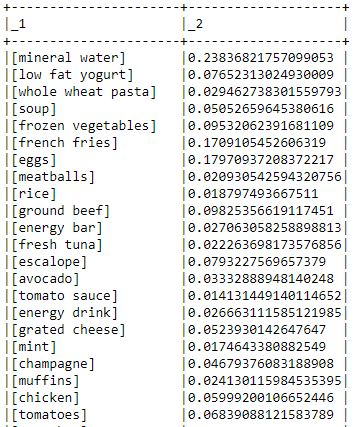

In [20]:
# Second order itemsets that have support value greater than the threshold (Print 20 rows)
freq_item_sets_all_orders[1].toDF().createTempView("freq_item_sets_2nd_orders_table")
spark.sql("select * from freq_item_sets_2nd_orders_table limit 20").show(20, truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------------------+--------------------+
|_1                           |_2                  |
+-----------------------------+--------------------+
|[pancakes, shrimp]           |0.010531929076123183|
|[burgers, pancakes]          |0.010531929076123183|
|[pancakes, spaghetti]        |0.025196640447940274|
|[frozen vegetables, pancakes]|0.013464871350486601|
|[chocolate, pancakes]        |0.01986401813091588 |
|[green tea, pancakes]        |0.01639781362485002 |
|[milk, pancakes]             |0.01653112918277563 |
|[eggs, pancakes]             |0.021730435941874418|
|[mineral water, pancakes]    |0.03372883615517931 |
|[french fries, pancakes]     |0.020130649246767097|
|[ground beef, pancakes]      |0.014531395813891481|
|[cake, pancakes]             |0.011865084655379284|
|[olive oil, pancakes]        |0.010798560191974404|
|[shrimp, spaghetti]          |0.021197173710171976|
|[frozen vegetables, shrimp]  |0.01666444474070124 |
|[chocolate, shrimp]          |0.0179976003199

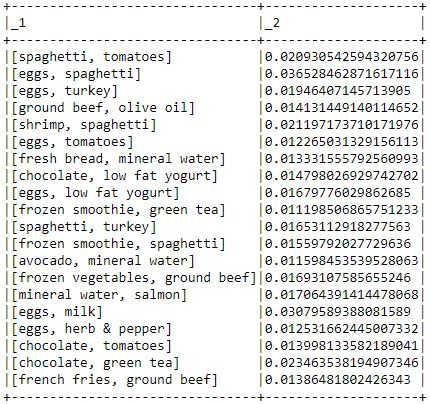

In [21]:
# Third order itemsets that have support value greater than the threshold (Print 20 rows)
freq_item_sets_all_orders[2].toDF().createTempView("freq_item_sets_3rd_orders_table")
spark.sql("select * from freq_item_sets_3rd_orders_table limit 20").show(20, truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------------------------------------+--------------------+
|_1                                           |_2                  |
+---------------------------------------------+--------------------+
|[mineral water, pancakes, spaghetti]         |0.011465137981602452|
|[frozen vegetables, mineral water, spaghetti]|0.011998400213304892|
|[chocolate, milk, spaghetti]                 |0.010931875749900012|
|[chocolate, eggs, spaghetti]                 |0.010531929076123183|
|[chocolate, mineral water, spaghetti]        |0.01586455139314758 |
|[milk, mineral water, spaghetti]             |0.01573123583522197 |
|[eggs, mineral water, spaghetti]             |0.014264764698040262|
|[french fries, mineral water, spaghetti]     |0.010131982402346354|
|[ground beef, mineral water, spaghetti]      |0.017064391414478068|
|[mineral water, olive oil, spaghetti]        |0.010265297960271964|
|[frozen vegetables, milk, mineral water]     |0.011065191307825623|
|[chocolate, milk, mineral water] 

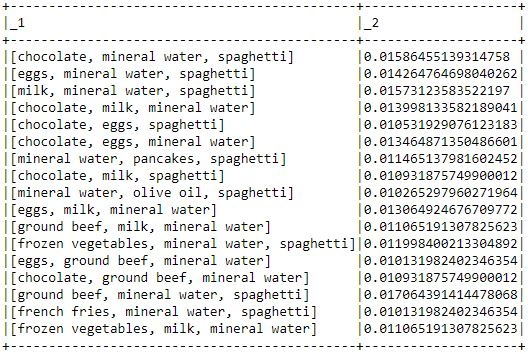

Congratulations! You now have your frequent itemsets. Let’s move on to Rule Generation. Hope you had no trouble
in completing the codes until now. If you have any doubts regarding the functions or commands used, you can keep a note of them and discuss in one of the live sessions.

The next part of the assignment is hard and involves patience to understand. You must try to understand the flow of the defined functions and should be able to understand what each function is doing.


### B. Rule generation

Let us refresh our memory on the properties of rules. 

Given the rule {A ---> B, C}:
- A is the antecedent
- (B, C) is the consequent

<br>
In mathematical terms, confidence is defined as: 

**Confidence = support(A, B, C) / support(A)**

<br>
Notice that {A, B, C} is the frequent itemset and A is the antecedent. Hence, in the set format, we can write the formula as:

**Confidence = support(Frequent Item Set) / support(Frequent Item Set - Consequent)**

Now, let's try to generate the confidence score. 

- The code for generating the rules is tough. Therefore, you are provided only with few blanks to fill based on the understanding of Spark and logic used.
- Due to the limitations of Spark, the code provides the confidence scores for single antecedant only. 

To calculate the confidence score, you will have to create subsets from the frequent item set to check all the possible combinations which may result in a higher confidence value than the threshold. Once you have all the subsets, you can use the support value associated with each subset to find the confidence score.

As the first step, we will create the subsets.

**powerset()**

In [22]:
# Function to generate all possible subsets from a set
# You can google powerset if you want to read more about it

def powerset(s):
    slist = list(s)
    result = [[]]
    for x in slist:
        
        # Here, you may want to explore what the purpose of function 'extend' is
        # Note that it is a reccursive function that adds elements to a list. It is similar to the extend() function in Python.
        result.extend([subset + [x] for subset in result])
        
    return [item_set for item_set in result if (len(item_set) > 0 and len(item_set) < len(slist))]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### Reasoning

Can you use the function append() in place of the function extend() in the above code?

In the above function we need to add multiple elements. `append()` adds a single element to the end of the list while. `extend()` can add multiple individual elements to the end of the list.

<br>**generate_rules_with_confidence**

The function will help you generate rules with the confidence score 
<br>

In [23]:
from pyspark.sql import Row

def generate_rules_with_confidence(x, k, freq_item_sets_map_all_orders_shared, min_confidence):
    
    """
    Attributes
    ----------
    
    x: freq_item_sets_all_orders; list that stores the frequent item set with the confidence score
    
    k: order of the frequent item set
    
    freq_item_sets_map_all_orders_shared: broadcasted map (key-value pair) of frequent item sets where 
    - key is the subset and 
    - value is the corresponding support
    
    min_confidence: Threshold confidence value 
    
    """
    
    # first column of the RDD is extracted as a frequent item set
    freq_item_set = set(x[0])
    
    # all_subsets stores all the subsets from the freq_item_set
    all_subsets = powerset(freq_item_set)
    
    # Defining an empty list to store the rules
    rules = []
    
    # Converting the broadcasted values in the required format (elements as tuple)
    freq_item_set_support = freq_item_sets_map_all_orders_shared[k].value[tuple(sorted(freq_item_set))]
    
    # Generated rules contain single element as antecendent. The reason is we used cross join for generating candidate
    # itemsets instead of doing or operation of two candidate sets as the for the later completely distributed approach
    # cannot be implemented.
    
    candidate_set_key = ''
    subset_k = 0
    for subset in all_subsets:
        antecedent = set(subset)
        
        # Consequent is generated by removing the antecedent from the frequent item set
        consequent = freq_item_set - set(antecedent)
    
        # Different calculation when there is a single element in consequent
        if (len(set(antecedent)) == 1):
            single_item = set(antecedent).pop()
            candidate_set_key = Row(_1=single_item)
            subset_k = 1
            set(antecedent).add(single_item)
        else:
            candidate_set_key = tuple(sorted(set(antecedent)))
            subset_k = len(set(antecedent))

        # support value for the consequent
        # value.get helps you to obtain only the value from the key-value pair
        antecedent_support = freq_item_sets_map_all_orders_shared[subset_k-1].value.get(candidate_set_key)
        
        if (antecedent_support is not None):
            
            # Calculating confidence value for the rule
            confidence = freq_item_set_support/antecedent_support
        
            # Addition of rule if the confidence value is above threshold
            if (confidence >= min_confidence):
                rules.append((list(antecedent), list(consequent), confidence))      

    return rules

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

**generate_association_rules_for_k_order** 

It generates association rules for frequent itemsets of order k 

In [24]:
def generate_association_rules_for_k_order(k, freq_item_sets_order_k, \
                                           freq_item_sets_map_all_orders_shared, min_confidence):
    """
    Attributes
    ----------
    
    k: order of the frequent item set
    
    freq_item_sets_map_all_orders_shared: broadcasted map (key-value pair) of frequent item sets where 
    - key is the subset and 
    - value is the corresponding support
    
    min_confidence: Threshold confidence value 
    
    """
    # Function generate_rules_with_confidence is called as flat map operation over the frequent itemsets of order k
    # Converting the final RDD into Dataframe and changing the column names
    return freq_item_sets_order_k.flatMap(lambda x: generate_rules_with_confidence(x, \
                                  k,freq_item_sets_map_all_orders_shared, \
                                  min_confidence)) \
                                     .toDF(('Antecedent', 'Consequent', 'Confidence'))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

**generate_association_rules**

It iterates over the all frequent itemsets of different orders and makes a union of association rules

In [25]:
def generate_association_rules(freq_item_sets_all_orders, min_confidence):
    
    """
    Attributes
    ----------
    
    freq_item_sets_all_orders: list of all frquent itemsets (calculated above) of different orders
    
    min_confidence: Threshold confidence value 
    
    """

    # As you can see, broadcast function is used here. It is used to broadcast a variable on all the executors.
    freq_item_sets_map_all_orders_shared = [spark.sparkContext.broadcast(freq_item_sets.collectAsMap()) \
                                                                     for freq_item_sets in freq_item_sets_all_orders]
    
    l = len(freq_item_sets_map_all_orders_shared)
    
    # Calling the function defined above to generate rules from frequent itemset of order 2
    # ___________
    association_rules_df = generate_association_rules_for_k_order(1, freq_item_sets_all_orders[1], \
                                                                  freq_item_sets_map_all_orders_shared, \
                                                                  min_confidence)
    
    for k in range(2, l):
        if is_freq_item_set_not_empty(freq_item_sets_all_orders[k]):
            # Creating union of all association rules for different frequent itemsets
            
            association_rules_df = association_rules_df.union(generate_association_rules_for_k_order(k, \
                                                        freq_item_sets_all_orders[k], \
                                                        freq_item_sets_map_all_orders_shared, min_confidence))
    return association_rules_df

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
# Applying the generate_association_rules function over the list of all frequent itemsets with threshold confidence
# score as 0.099 - Values greater than 1 will be used in the marketing strategies

association_rules = generate_association_rules(freq_item_sets_all_orders, 0.099)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
# Printing all the association rules

association_rules.show(300, truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------------------------+--------------------------+-------------------+
|Antecedent                        |Consequent                |Confidence         |
+----------------------------------+--------------------------+-------------------+
|[pancakes]                        |[shrimp]                  |0.11079943899018233|
|[shrimp]                          |[pancakes]                |0.14738805970149252|
|[burgers]                         |[pancakes]                |0.12079510703363913|
|[pancakes]                        |[burgers]                 |0.11079943899018233|
|[spaghetti]                       |[pancakes]                |0.1447166921898928 |
|[pancakes]                        |[spaghetti]               |0.2650771388499299 |
|[pancakes]                        |[frozen vegetables]       |0.14165497896213183|
|[frozen vegetables]               |[pancakes]                |0.14125874125874124|
|[pancakes]                        |[chocolate]               |0.20897615708

In [28]:
# Export all the assciation rules in a csv file and copy them to the Excel file provided


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Now you have got the association rules based on the transaction dataset. The next part of the assignment will involve using these rules to calculate the expected revenue from the two strategies